In [104]:
### %reload_ext autoreload

%reset

import sys
sys.path.append("../") 

import numpy as np
import scipy.interpolate
from scipy.stats import poisson
from scipy.stats import uniform
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp

#For making corner plots
from getdist import plots, MCSamples

import pdb

import EPDFABC as epdfabc
import subhalos as subs
import FermiBackgrounds
import DMsignal

import pickle as pk

import elfi

matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

#matplotlib.use('PS')

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [105]:
load_pf = True
save_pf = False

channel = 'Tau'
if (channel == 'Tau'):
    suffix = 'tau_default_NE10_MMin1_10yr_masked01'
if (channel == 'b'):
    suffix = 'b_default_NE10_MMin1_10yr_masked01'    


my_DM = DMsignal.DMsignal('../data/dm_spectra/', channel)
default_param_dict = my_DM.get_default_model()
default_params = np.array([default_param_dict['A_DM'],\
                           default_param_dict['A_BG'],\
                           default_param_dict['mass_DM_MeV']])
print("default params = ", default_param_dict)

physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')

print(physics_settings)
print(obs_settings)

#Count and energy ranges
count_range = [0, 700] #this is larger than max c, since it is *total* counts from all sources
energy_range = [1000, 100000] #this is in MeV, important since used for backgrounds
nbins_summary = 30 #15
cmax_summary = 150 #75
    
# Set up background generator
fermi_data_path = '../data/FermiData/'
background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)

#Bin settings
N_E_bins = 10
#Bin settings
summary_properties = {'type': 'histogram' ,'Nbins':nbins_summary, \
                      'Cmax_hist': cmax_summary, 'Cmin_hist': count_range[0], 'logbins':False,
                     'energy_bins_to_use':0 #setting this to a scalar ensures that number of energy bins matches
                      #binning of data
                     }



default params =  {'A_DM': 200.0, 'A_BG': 1.0, 'mass_DM_MeV': 200000.0}
{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}


In [106]:
# Settings for subhalo analysis
default_phipp = physics_settings['PhiPP']
N_pix_fullsky = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix_fullsky/12.0))

exposure = ((obs_settings['obs_time']*units.yr * obs_settings['area']*units.cm**2).to('s*cm**2')).value
Sangle = obs_settings['Omega_pixel']


print("N_side = ", N_side)

N_side =  64


In [107]:
#sky masking
do_mask = True
if (not do_mask):
    N_pix = N_pix_fullsky
    mask = np.ones(N_pix)
    gal_lat_cut = 0.
    gal_cent_cut = 0.
else:
    gal_lat_cut = 30.
    gal_cent_cut = 60.
    mask = background_generator.get_mask(N_side, gal_lat_cut, gal_cent_cut)
    
    mask_indices = np.where(mask > 0)[0]
    N_pix = len(mask_indices)


In [108]:
# Compute the PDF of photon counts using the Fourier transform trick.  Note that this can be slow.
if (not load_pf):
    maxc = 100.
    counts = np.arange(0,maxc)
    print(physics_settings)
    pc, f_pf_precomputed, pf_pf_precomputed = subs.get_pc(counts, physics_settings, fft_settings, \
                                                             obs_settings, return_fpf = True)
    if save_pf:
        pf_data = {'maxc':maxc, 'pc':pc, 'counts':counts, 'f_pf_precomputed':f_pf_precomputed, \
                   'pf_pf_precomputed':pf_pf_precomputed}
        pk.dump(pf_data, open('../data/pf_calculation/pf_saved_hires_mmin1.pk','wb'))
else:
    pf_data = pk.load(open('../data/pf_calculation/pf_saved_hires_mmin1.pk','rb'))
    maxc = pf_data['maxc']
    pc = pf_data['pc']
    counts = pf_data['counts']
    
    f_pf_precomputed = pf_data['f_pf_precomputed']
    pf_pf_precomputed = pf_data['pf_pf_precomputed']
    

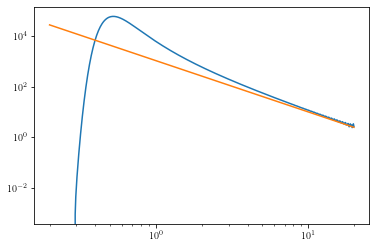

In [109]:
# Check on P(F)
fig, ax = pl.subplots(1,1)
ax.plot(f_pf_precomputed*obs_settings['area']*obs_settings['obs_time'], pf_pf_precomputed)
ax.plot(f_pf_precomputed*obs_settings['area']*obs_settings['obs_time'], 2.0e-6*f_pf_precomputed**(-1.03 - 1.))
ax.set_xscale('log')
ax.set_yscale('log')

In [110]:
#Backgrounds

# Energy spectrum setup
#We use FermiBackgrounds to get the background spectrum and mean flux
fermi_iso = background_generator.get_isotropic_background_spectrum_func()
mean_iso_bg_flux = background_generator.get_masked_isotropic_flux('../data/FermiData/galactic_bg_healpix_Nside64.pk',\
                                                gal_lat_cut, gal_cent_cut, energy_range[0], energy_range[1])

In [111]:
#set up wrappers for pdf and spectra
def subhalo_pdf_wrapper(params, counts, args):
    A_DM = params[0]
    mass_DM_MeV = params[2]
    
    #DMe, DMdnde = DMsignal.get_signal_spectrum(DMchannel, DMmass)
    #DMspectrum = scipy.interpolate.interp1d(DMe, DMdnde)
    E = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), 1000))
    dE = E[1:] - E[:-1]
    dNdE = my_DM.get_dNdE(E, channel, mass_DM_MeV)

    PhiInt = np.sum(0.5*dE*(dNdE[1:]+dNdE[:-1]))
    sigv = 3e-26 #cm^3 s^-1 # fiducial cross section for thermal relic DM
    PhiPP = sigv*A_DM*PhiInt/(8*np.pi*(mass_DM_MeV/1e3)**2)
    PhiPP_0 = (1e-28)/(8*np.pi) #cm^3 s^-1 GeV^-2
    temp  = sigv*PhiInt/(8*np.pi*(mass_DM_MeV/1e3)**2)
        
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
    physics_settings['PhiPP'] = PhiPP/PhiPP_0
    pc = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, \
                          physics_settings, fft_settings, obs_settings, \
                          default_phipp = default_phipp, do_extend = True)
    pc = pc/np.sum(pc)
    return pc

def subhalo_spec_wrapper(params, energy, args):
    mass_DM_MeV = params[2]
    return my_DM.get_dNdE(energy, channel, mass_DM_MeV)

def background_pdf_wrapper(params, counts, args):
    #Our model for the background is that it is Poisson distributed with
    #mean given by params[1]*mean_flux_from_fermi_isotropic_model
    mean_iso_bg = mean_iso_bg_flux*exposure*Sangle
    #Assuming Poisson background
    background_pc = poisson.pmf(counts, mean_iso_bg*params[1])    
    return background_pc

def background_spec_wrapper(params, energy, args):
    #Using Fermi isotropic background model for spectrum
    #This is a bit weird, since this background includes non-Poisson sources (e.g. blazars)
    return fermi_iso(energy)


param_names = ['PhiPP', 'bgnorm', 'MDM_MeV']
param_labels = ['\\Phi_{PP}', '\\A_{\rm bg}', '\\M_{\chi}']
param_min = np.array([0.5*default_params[0], 0.985*default_params[1], 0.5*default_params[1]])
param_max = np.array([1.5*default_params[0], 1.015*default_params[1], 1.5*default_params[1]])
param_range = [param_min, param_max]
PDF_and_spectra = [[background_pdf_wrapper, background_spec_wrapper], \
                   [subhalo_pdf_wrapper, subhalo_spec_wrapper]]
is_isotropic_list = [True, True]
is_poisson_list = [False, False]

In [112]:
#We'll use the EPDFABC object to generate the mock maps

# initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range)

#Setup for binned analysis
my_abc.setup_binned(PDF_and_spectra, is_isotropic_list, is_poisson_list, count_range, \
                    energy_range, N_E_bins, obs_settings['Omega_pixel'], verbose = False)

(1, 20424, 10)


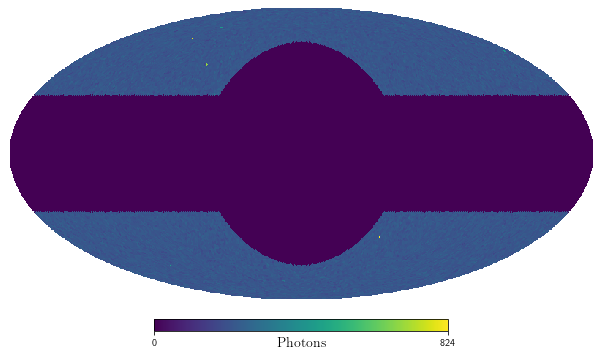

In [120]:
load_data = False
if (not load_data): 
    #draw mock data
    mock_sky = my_abc.generate_mock_data_binned(default_params, exposure = exposure, N_pix = N_pix)
    mask_indices = np.where(mask > 0)[0]
if (load_data):
    skymap_filename = 'skymap_' + suffix + '.pk'
    skydict = pk.load(open('../data/skymaps/' + skymap_filename, 'rb'))
    mock_sky = skydict['obs_data']
    mask_indices = np.where(skydict['mask'] > 0)[0]

#mock_sky = my_abc.generate_mock_data_binned(default_params, N_pix = N_pix)
print(mock_sky.shape)

#Sum over energies
mock_data = np.sum(mock_sky[0,:,:], axis = 1)

if (not do_mask):
    mock_sky_to_plot = mock_data
else:
    mock_sky_to_plot = np.zeros(N_pix_fullsky)
    mock_sky_to_plot[mask_indices] = mock_data

hp.mollview((mock_sky_to_plot), title= '', unit = r'${\rm Photons}$')
pl.savefig('sky_map_masked_' + channel + '.pdf', format = 'pdf')

 <ipython-input-121-35ee659f8db7>:16: RuntimeWarning:divide by zero encountered in log10


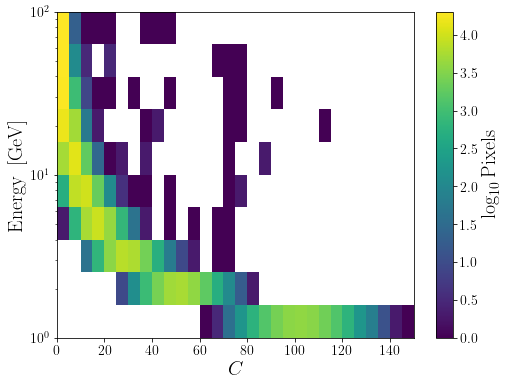

In [121]:
summary_flat = my_abc.get_summary_from_binned(mock_sky, summary_properties = summary_properties)
summary = summary_flat[0,:].reshape((N_E_bins, summary_properties['Nbins'])).transpose()
Ebin_edges = my_abc.Ebins
Cbin_edges = np.linspace(summary_properties['Cmin_hist'], summary_properties['Cmax_hist'], \
                    num = summary_properties['Nbins']+1)
Ecents = 0.5*(Ebin_edges[1:] + Ebin_edges[:-1])

fig,ax = pl.subplots(1,1, figsize = (8,6))
fig.subplots_adjust(wspace=.5)

#ax.imshow(summary, origin = 'lower', extent=[np.min(Cbins), np.max(Cbins), np.min(Ebins), np.max(Ebins)])
#ax.contourf(Ecents, Cbins, summary)
#ax.set_yscale('log')
#ax.set_xscale('log')

pm = ax.pcolormesh(Cbin_edges, Ebin_edges/1000., np.log10(summary).transpose())
ax.set_yscale('log')

label_size = 20
tick_size = 14

cb = fig.colorbar(pm, ax=ax)
cb.set_label(label= r'$\log_{10}{\rm Pixels}$', size = label_size)
cb.ax.tick_params(labelsize=tick_size) 

ax.set_xlabel(r'$C$', fontsize = label_size)
ax.set_ylabel(r'${\rm Energy\,\,\,[GeV]}$', fontsize = label_size)

ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_size)

fig.savefig('summary_stat_masked_' + channel + '.pdf')



mean dm =  0.7201030332457755


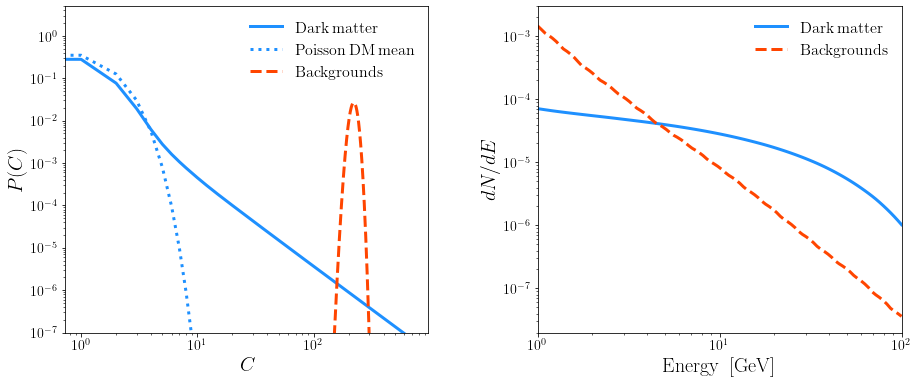

In [118]:
counts_plot = np.arange(count_range[0], count_range[1])
pc_dm = subhalo_pdf_wrapper(default_params, counts_plot,{})
pc_bg = background_pdf_wrapper(default_params, counts_plot,{})

dm_color = 'dodgerblue'
bg_color = 'orangered'
label_fontsize = 20 
legend_fontsize = 16
tick_size = 14

fig, ax = pl.subplots(1,2, figsize = (15,6))
fig.subplots_adjust(wspace = 0.3)
#ax.plot(counts_orig, pc_orig, label = 'original')
ax[0].plot(counts_plot, pc_dm, label = r'${\rm Dark\,matter}$', lw = 3, color = dm_color)
mean_dm = np.sum(counts_plot*pc_dm)
print("mean dm = ", mean_dm)
ax[0].plot(counts_plot, poisson.pmf(counts_plot, mean_dm), \
           label = r'${\rm Poisson\,DM\,mean}$', lw = 3, ls = 'dotted', color = dm_color)

ax[0].plot(counts_plot, pc_bg, label = r'${\rm Backgrounds}$', lw = 3, ls = 'dashed', color = bg_color)
ax[0].set_xlabel(r'$C$', fontsize = label_fontsize)
ax[0].set_ylabel(r'$P(C)$', fontsize = label_fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(fontsize = legend_fontsize, frameon = False)
ax[0].set_ylim((1.0e-7, 5.0))
ax[0].tick_params(axis='both', which='major', labelsize=tick_size)
ax[0].tick_params(axis='both', which='minor', labelsize=tick_size)


#Spectrum


# Energy spectrum setup
#We use FermiBackgrounds to get the background spectrum and mean flux
fermi_data_path = '../data/FermiData/'
background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)
#fermi_iso = background_generator.get_isotropic_background_spectrum_func()
#mean_iso_bg_flux = background_generator.get_mean_isotropic_flux(energy_range[0], energy_range[1])
fermi_iso = background_generator.get_isotropic_background_spectrum_func()
mean_iso_bg_flux = background_generator.get_masked_isotropic_flux('../data/FermiData/galactic_bg_healpix_Nside64.pk',\
                                                gal_lat_cut, gal_cent_cut, energy_range[0], energy_range[1])

E_plot = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), 100))
dE_plot = E_plot[1:] - E_plot[:-1]

dNdE_iso = background_spec_wrapper(default_params, E_plot,{})
dNdE_DM = subhalo_spec_wrapper(default_params, E_plot,{})
dNdE_iso = dNdE_iso/np.sum(dE_plot*dNdE_iso[1:])
dNdE_DM = dNdE_DM/np.sum(dE_plot*dNdE_DM[1:])

ax[1].plot(E_plot/1000., dNdE_DM, label = r'${\rm Dark\,matter}$', color = dm_color, lw = 3)
ax[1].plot(E_plot/1000., dNdE_iso, label = r'${\rm Backgrounds}$', color = bg_color, lw = 3, ls = 'dashed')
ax[1].set_ylabel(r'$dN/dE$', fontsize = label_fontsize)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'${\rm Energy \,\,\,[GeV]}$', fontsize = label_fontsize)
ax[1].legend(fontsize = legend_fontsize, frameon = False)
ax[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax[1].tick_params(axis='both', which='minor', labelsize=tick_size)
ax[1].set_ylim((2.0e-8, 30.0e-4))
ax[1].set_xlim((1.0, 100.))


fig.savefig('example_masked_spectrum_' + channel + '.pdf')